# Inference

- Run inference on the test dataset.
- Mainly for testing your model is doing ok visually.
- This is not meant to be used in production (see [Export_and_Packing](./5_Export_and_Packing.ipynb)).

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import tqdm
import torch
import numpy as np

import sys; sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Nucleus")
data_dir = root_dir / "Data"
model_dir = root_dir / "Models"
model_dir.mkdir(exist_ok=True)

# Import the configuration associated with this dataset and network.
config = maskflow.config.load_config(root_dir / "config.yaml")

In [2]:
# Select the model
model_name = '2018.11.04-17:31:08'
model_path = model_dir / model_name

# Set some configurations
config['MODEL']['DEVICE'] = "cpu"
config['DATALOADER']['NUM_WORKERS'] = 4
config['TEST']['IMS_PER_BATCH'] = 1
config['SOLVER']['IMS_PER_BATCH'] = 1
batch_to_load = 4

# Build the model
model = maskflow.inference.build_model(config, model_path)

# Load some data
data_loader = maskflow.dataset.get_data_loader(config, data_dir, is_train=False)
data = [datum for _, datum in zip(range(batch_to_load), data_loader)]

# Retrieve category's names
categories = data_loader.dataset.coco.cats

# Run inference
predictions = []
images = []
ground_truth = []
for batch_image, batch_target, batch_idx in data:
    batch_image = batch_image.to(config['MODEL']['DEVICE'])
    with torch.no_grad():
        prediction = model(batch_image)
        prediction = [o.to('cpu') for o in prediction]
        predictions.extend(prediction)
        images.extend([im for im in batch_image.tensors])
        ground_truth.extend(batch_target)
        
images = np.array([o.to('cpu').numpy() for o in images])
len(images)

2018-11-04 17:47:19,943:INFO:maskrcnn_benchmark.utils.checkpoint: Loading checkpoint from /home/hadim/.data/Neural_Network/Maskflow/Nucleus/Models/2018.11.04-17:31:08/model_0000400.pth
2018-11-04 17:47:20,166:WARNING:maskrcnn_benchmark.data.build: When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14


loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


8

49
tensor([0.9919, 0.9888, 0.9887, 0.9887, 0.9884, 0.9881, 0.9877, 0.9851, 0.9843,
        0.9833, 0.9821, 0.9812, 0.9806, 0.9797, 0.9790, 0.9775, 0.9749, 0.9745,
        0.9734, 0.9687, 0.9680, 0.9662, 0.9597, 0.9587, 0.9584, 0.9575, 0.9565,
        0.9547, 0.9543, 0.9521, 0.9498, 0.9478, 0.9430, 0.9422, 0.9419, 0.9419,
        0.9210, 0.9182, 0.9073, 0.8759, 0.8669, 0.8602, 0.8445, 0.8404, 0.8179,
        0.7879, 0.7873, 0.7393, 0.7203])


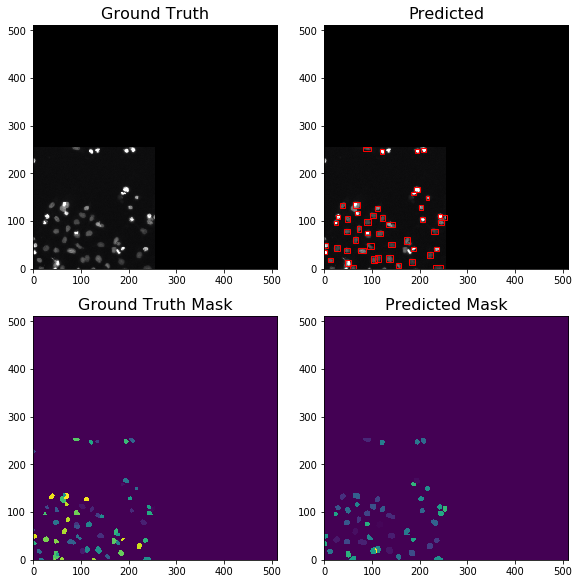

In [5]:
# Show prediction
idx = 7
image = images[idx]
prediction = predictions[idx]
gt = ground_truth[idx]

prediction = maskflow.inference.post_process_predictions(prediction, image,
                                                         confidence_threshold=0.7,
                                                         mask_threshold=0.5)

print(prediction.bbox.shape[0])
print(prediction.get_field('scores'))

_ = maskflow.viz.display_prediction_and_gt(image, prediction, gt, class_names=config['CLASS_NAMES'],
                                           pixel_mean=config['INPUT']['PIXEL_MEAN'],
                                           pixel_std=config['INPUT']['PIXEL_STD'])